In [1]:
from site_visit import *
from feature_functions import *

import json
import os
import random

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.patches import Patch

prop_cycle = plt.rcParams['axes.prop_cycle']
color_lst = prop_cycle.by_key()['color']

color_lst = px.colors.qualitative.Light24

## Setup for Model Eval

In [2]:
# this takes a couple minutes
spatial_data = load_all_spatial_data("data/spatial_mini_for_debug.txt",
                                    fnames = None)

0 3_1b task1


In [7]:
# can manually override options in config here, the condif will be logged later
# after running eval
config = json.loads(open('config.json').read())


# set up directories for logging and saving results
inp = config['MODE'].split('.')[0].split('/')[-1]
inp += '_' + name_from_config(config)

rootdir = 'results/%s/'%inp
if not os.path.exists(rootdir):
    os.makedirs(rootdir)

In [4]:
# featurize data, see feature_functions.py for feature extraction code
(vocab_lsts, count_lsts, top_words_candidates,
    all_data, feat_names) = prep_data(config, spatial_data, logdir=rootdir,
                                      use_cnn=config["MODEL_TYPE"] == "2d")

sys.stderr.write("X: %s x %s\n"%all_data.X.shape)
sys.stderr.write("y: 1 x %s\n"%len(all_data.y))

Data: 18826 items
Word Vocab=9295
Filtered Data: 968 items


feats (968, 53)


X: 968 x 53
y: 1 x 968


In [6]:
# filters to only words of interest, can switch top_word_candidates to be any list
# of words, it just needs to be a list of strings in LEMMA_POS format.
# Also filters to one instance of a word per participant and task. This is something 
# I tried to do to reduce overfitting. I don't think its critical anymore, so worth removing
# that step if we can do so without hurting results.
filtered_data = filter_and_dedup(all_data, top_words_candidates)

# note this step is here because top_words might be different
# than top_word_candidates, if some words in the specified list 
# never actually occur in the data
top_words = list(set(filtered_data.y))
print(top_words)
train, dev, test = train_test_split(filtered_data, config['TEST'], config['DEV'])


['stop_VERB', 'open_VERB', 'walk_VERB', 'take_VERB', 'throw_VERB', 'drop_VERB', 'play_VERB', 'hold_VERB', 'pick_VERB', 'put_VERB', 'get_VERB', 'wash_VERB', 'eat_VERB', 'give_VERB', 'go_VERB']


## Run Model Eval

In [9]:
if config['RED'] == True:
    trained_reducer = reduce_mats(
                train, dev, test,
                dim=config['DIM'], supervised=config['SUP'])
    red_X_train = trained_reducer.transform(train.X)
    red_X_dev = trained_reducer.transform(dev.X)
    train.X = red_X_train
    dev.X = red_X_dev
    print("X_train:", train.X.shape)
    print("X_dev:", dev.X.shape)
    
repdir, figdir = make_directories(config, rootdir)
json.dump(config, open(repdir+'/config.json', 'w'))

X_train: (389, 10)
X_dev: (27, 10)


Number of classes = 15
Training size = 389 x 53
Dim to reduce to = 10.000
/Users/ellie/miniconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning:

The priors do not sum to 1. Renormalizing

/Users/ellie/miniconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Worst-Case Baseline:	0.07
Random Baseline:	0.22 (0.12 -- 0.35)	0.20
Macro Avg. MRR:	0.30	0.29


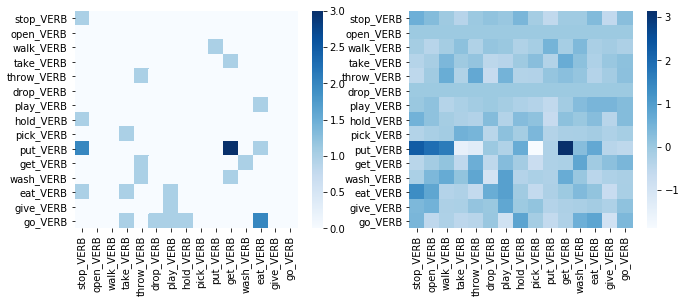

In [10]:
mn = train.X.min()
mx = train.X.max()
avg_train, std_train = avg_mat(train, top_words)

# computes MRR and P@K for true word. Note this is our "hacky eval", its hard to 
# read too much into improvements/setbacks reflected by these numbers. I prefer
# using the proper manual eval (called "blind eval" below)
generate_results_reports(avg_train, dev.X, top_words, dev.y, None,
                         dev.meta, repdir, save=config['LOG'])

## Blind Eval

In [11]:
# This takes the trained model and uses it to label every 5-second clip of the held out subject's
# data. We can then manually label these to perform a better eval.
blind = eval_on_random(config, spatial_data, vocab_lsts, count_lsts, use_cnn=config["MODEL_TYPE"] == "2d")
print(blind.X.shape)

if config['RED'] == True:
    blind.X = trained_reducer.transform(blind.X)
    
outfile = open('%s/blind_eval.txt'%repdir, 'w')

sims = cosine_similarity(blind.X, avg_train)

for i in range(len(blind.meta)):
    
    max_idxs = [e for e in reversed(sims[i, :].argsort())] # to get descending order
    plst = []
    for idx in max_idxs:
        plst.append('%s=%.04f'%(top_words[idx], sims[i, idx]))
    
    outfile.write('model\t%s\t%s\t%s\t%s\n'%(blind.meta[i], blind.y[i],
                                             plst[0].split('=')[0], '\t'.join(plst)))
    
    # Include random labels as well, so that we can shuffle and label and not bias ourselves 
    # by knowing which model we are labeling
    outfile.write('rand\t%s\t%s\t%s\t%s\n'%(blind.meta[i], blind.y[i],
                                            random.choice(plst).split('=')[0], '\t'.join(plst)))
outfile.close()

Data: 107 items


feats (107, 53)
(107, 53)


## Figures

In [12]:
#reducer = TruncatedSVD(n_components=2)
reducer = TSNE(n_components=2, perplexity=10)
red = reducer.fit_transform(np.vstack((train.X, dev.X, avg_train)))
print(red.shape)

(389, 10)
(27, 10)
(15, 10)
(431, 2)


['drop_VERB', 'eat_VERB', 'get_VERB', 'give_VERB', 'go_VERB', 'hold_VERB', 'open_VERB', 'pick_VERB', 'play_VERB', 'put_VERB', 'stop_VERB', 'take_VERB', 'throw_VERB', 'walk_VERB', 'wash_VERB']
['10_2b', '11_1c', '12_2c', '13_1a', '14_2a', '15_1b', '16_2b', '17_1c', '18_2c', '1_1a', '2_2a', '3_1b', '5_1c', '6_2c', '7_1a', '8_2a', '9_1b']


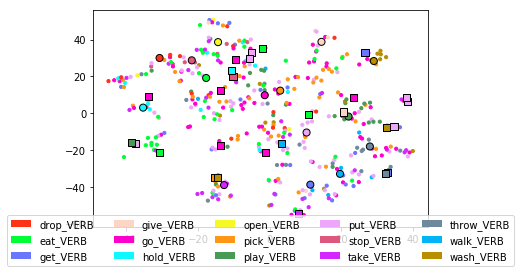

In [13]:
#plt.figure(figsize=(8,8))
#plt.rcParams["figure.figsize"] = [8,8]
fig, ax = plt.subplots()

word_order = sorted(list(set(train.y)))
part_order = sorted(list(set([e.split()[0] for e in train.meta])))
print(word_order)
print(part_order)
train_end = train.X.shape[0]
dev_end = train_end + dev.X.shape[0]
avg_train_end = dev_end + len(top_words)
avg_dev_end = avg_train_end + len(top_words)

color_by_word = True

L = len(color_lst)

# train words
if color_by_word:
    tr_colors = [color_lst[word_order.index(y)%L] for y in train.y if y in word_order]
    dv_colors = [color_lst[word_order.index(y)%L] for y in dev.y if y in word_order]
else:
    tr_colors = [color_lst[part_order.index(p.split()[0])%L] for p in train.meta]
    dv_colors = [color_lst[part_order.index(p.split()[0])%L] for p in dev.meta]
    
plt.scatter(red[:train_end, 0], red[:train_end, 1], s=10, color=tr_colors)

# centroids of train words
if color_by_word:
    plt.scatter(red[dev_end:avg_train_end, 0], red[dev_end:avg_train_end, 1], s=50,
            color=[color_lst[word_order.index(y)%L] for y in top_words], linewidth=1, edgecolor='k')

# dev words
plt.scatter(red[train_end:dev_end, 0], red[train_end:dev_end, 1], s=50, color=dv_colors,
            marker='s', linewidth=1, edgecolor='k')

if color_by_word:
    legend_elements = [Patch(facecolor=color_lst[i%L], label=word_order[i]) for i in range(len(word_order))]
else:
    legend_elements = [Patch(facecolor=color_lst[i%L], label=part_order[i]) for i in range(len(part_order))]
plt.legend(handles=legend_elements, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.2))

plt.show()

## Code for precomputing ResNet Features for CNN Baselines

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from pretrained_cnns.alexnet import alexnet
from pretrained_cnns.vgg import vgg19
from pretrained_cnns.vgg import vgg11
from pretrained_cnns.resnet import resnet101
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image

resnet = resnet101(pretrained=True)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# compute cnn data for every embedding
# this is slow but gets the job done for now

def get_emb(p, t, s):
    img_path = 'cnn_baselines/images/%s/%s_task%s/%s.png'%(p, p, t, s)
    if os.path.exists(img_path):
        #sys.stderr.write('%s\n'%img_path)
        input_tensor = preprocess(Image.open(img_path))
        input_batch = input_tensor.unsqueeze(0)
        with torch.no_grad():
            return resnet.forward(input_batch)
                
out = open('cnn_embeddings.txt', 'w')

top_words = get_top_words(config['POS'])
_data = [row for row in csv.DictReader(open(config['DATA']), delimiter='\t')]
_data = [d for d in _data if '%s_%s'%(d['lemma'], d['pos']) in top_words]
print("len(_data)", len(_data))

done = set()
with open('cnn_embeddings_backup.txt') as f:
    for line in f:
        p, t, s, _ = line.strip().split('\t')
        done.add('%s-%s-%s'%(p, t, s))
#for midx, m in enumerate(filtered_data.meta):
    #p, t, _, se = m.split()
    #s, e = se.split('-')
    #if midx % 100 == 0:
for idx, d in enumerate(_data):
    p = d['participant']
    t = d['task'][-1]
    i = int(d['step'])

    if i % 10 == 0:
        sys.stderr.write('%s %s\n'%(p, t))
        
    if '%s-%s-%s'%(p, t, i) not in done:
        resout = get_emb(p, t, i)
        if resout is not None:
            out.write('%s\t%s\t%s\t%s\n'%(p, t, i,
                                    ' '.join(['%s'%v.item() for v in resout])))
    s = 10 * (int(i/10))
    for j in range(s, s+config['WINDOW'], 100):
        if '%s-%s-%s'%(p, t, j) in done:
            continue
        try:
            resout = get_emb(p, t, s)
        except OSError:
            print("OSError on %s %s %s"%(p, t, i))
            continue
        if resout is not None:
            out.write('%s\t%s\t%s\t%s\n'%(p, t, j,
                                    ' '.join(['%s'%v.item() for v in resout])))
out.close()


In [ ]:
_data = [row for row in csv.DictReader(open(config['DATA']), delimiter='\t')]
_data = [d for d in _data if (d['participant'] == '10_2b') and (d['step'][-1] == '0')]
for d in _data[:5]:
    img_path = 'cnn_baselines/images/%s_task%s/%s.png'%(d['participant'],
                                                        d['task'], d['step'])
    input_tensor = preprocess(Image.open(img_path))
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        resout = resnet.forward(input_batch)
        print(resout)

In [ ]:
dataset = datasets.ImageFolder('cnn_baselines/images/', transform=preprocess)
data_loader = DataLoader(dataset, batch_size=1000)

In [ ]:
with torch.no_grad():
    for img, lbl in data_loader:
        resout = resnet.forward(img)
        print(resout)
        break